
# Project Title : Analysis of COVID-19 vaccine sentiments and opinions on Twitter


Import library and download packages required for project

In [203]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions
import itertools
import collections
import string
pd.set_option("display.max_colwidth", 200) 


import nltk # for text manipulation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon') # Download the VADER lexicon


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [204]:
# Connect Google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [205]:
#Reading the dataset drom excel file
data_read =  pd.read_excel("drive/MyDrive/Twitter Project/Final Dataset/Covishield.xlsx")

In [206]:
#Tranfer dataset to anaother variable for further processing
data_df = data_read

**Exploring Our Dataset**

In [207]:
#Checking dataset varaiable
data_df.head()

,id,date,content,username
0,Remya Ravindran44066.73125,2020-08-23,https://t.co/XNl4TZ4nJe\nLive on covid vaccine \n#CovidVaccine\n#CoviShield\n#OxfordVaccine\n#SerumInstituteofIndiaâ€,Remya Ravindran
1,Remya Ravindran44066.7291666667,2020-08-23,https://t.co/CrQjchm5eQ\nLive on covid vaccine \n#CovidVaccine\n#CoviShield\n#OxfordVaccine\n#SerumInstituteofIndiaâ€,Remya Ravindran
2,IANS Tweets44066.4291666667,2020-08-23,"""#Covishield will be commercialised once the trials are proven successful and all the requisite regulatory approvalâ€",IANS Tweets
3,Nation Next44064.6604166667,2020-08-23,"Fact check: No, Indiaâ€™s vaccine â€˜Covishieldâ€™ is not going to be commercialized in 73 days\n\nhttps://t.co/6yupMwD9gXâ€",Nation Next
4,Sakal Times44070.4458333333,2020-08-23,https://t.co/XNl4TZ4nJe\nLive on covid vaccine \n#CovidVaccine\n#CoviShield\n#OxfordVaccine\n#SerumInstituteofIndiaâ€,Remya Ravindran


In [208]:
#Renaming Column headers
data_df.rename(columns = {'content':'OriginalTweet','date':'Date','username':'Username','id':'Id'}, inplace = True)

In [209]:
data_df.head(2)

,Id,Date,OriginalTweet,Username
0,Remya Ravindran44066.73125,2020-08-23,https://t.co/XNl4TZ4nJe\nLive on covid vaccine \n#CovidVaccine\n#CoviShield\n#OxfordVaccine\n#SerumInstituteofIndiaâ€,Remya Ravindran
1,Remya Ravindran44066.7291666667,2020-08-23,https://t.co/CrQjchm5eQ\nLive on covid vaccine \n#CovidVaccine\n#CoviShield\n#OxfordVaccine\n#SerumInstituteofIndiaâ€,Remya Ravindran


In [210]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20150 entries, 0 to 20149
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             20149 non-null  object        
 1   Date           20150 non-null  datetime64[ns]
 2   OriginalTweet  20150 non-null  object        
 3   Username       20150 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 629.8+ KB


In [211]:
data_df.shape

(20150, 4)

In [212]:
# Check null values
data_df.isnull().sum()

Id               1
Date             0
OriginalTweet    0
Username         0
dtype: int64

In [213]:
#Removing Duplicate tweets 
data_df = data_df.drop_duplicates('OriginalTweet')
print(data_df.shape)


(18744, 4)


**Unique Values In Each Feature Coulmn**

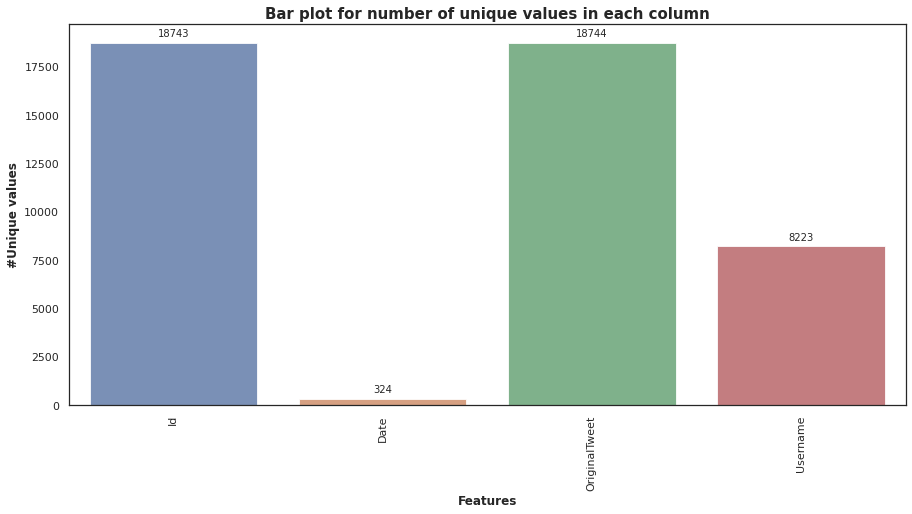

In [214]:
unique_df = pd.DataFrame()
unique_df['Features'] = data_df.columns
unique=[]
for i in data_df.columns:
    unique.append(data_df[i].nunique())
unique_df['Uniques'] = unique

f, ax = plt.subplots(1,1, figsize=(15,7))

splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

In [215]:
#Checking timeline of tweets
data_df['Date'].sort_values()

0       2020-08-23
1       2020-08-23
2       2020-08-23
3       2020-08-23
7       2020-08-23
           ...    
20115   2021-12-17
20116   2021-12-17
20117   2021-12-17
20104   2021-12-17
20149   2021-12-17
Name: Date, Length: 18744, dtype: datetime64[ns]

**Top 10 dates of tweet**

In [216]:
Most_tweet_Date = data_df['Date'].value_counts().head(10)
rc={'figure.figsize':(12,8)}
sns.set_style('white')

Most_tweet_Date_df=pd.DataFrame(Most_tweet_Date)
Most_tweet_Date_df.reset_index(inplace=True)
Most_tweet_Date_df.rename(columns={'index':'Date', 'Date':'Date_Count'}, inplace=True)
Most_tweet_Date_df

,Date,Date_Count
0,2021-04-21,250
1,2021-05-13,234
2,2021-06-30,215
3,2021-05-25,196
4,2021-07-03,192
5,2021-07-01,175
6,2021-05-28,153
7,2021-05-27,152
8,2021-05-29,152
9,2021-04-26,146


[Text(0, 0, '2021-04-21T00:00:00.000000000'),
 Text(0, 0, '2021-05-13T00:00:00.000000000'),
 Text(0, 0, '2021-06-30T00:00:00.000000000'),
 Text(0, 0, '2021-05-25T00:00:00.000000000'),
 Text(0, 0, '2021-07-03T00:00:00.000000000'),
 Text(0, 0, '2021-07-01T00:00:00.000000000'),
 Text(0, 0, '2021-05-28T00:00:00.000000000'),
 Text(0, 0, '2021-05-27T00:00:00.000000000'),
 Text(0, 0, '2021-05-29T00:00:00.000000000'),
 Text(0, 0, '2021-04-26T00:00:00.000000000')]

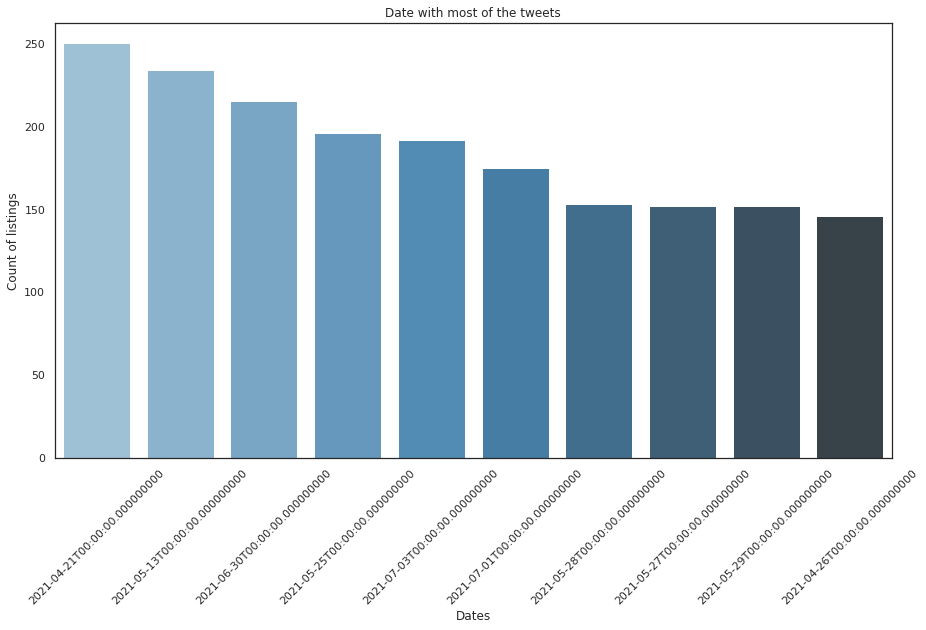

In [217]:
fig = plt.figure(figsize=(15, 8))
viz_1=sns.barplot(x="Date", y="Date_Count", data=Most_tweet_Date_df,
                 palette='Blues_d')
viz_1.set_title('Date with most of the tweets')
viz_1.set_ylabel('Count of listings')
viz_1.set_xlabel('Dates')
viz_1.set_xticklabels(viz_1.get_xticklabels(), rotation=45)

**Bottom 10 dates of tweet**

In [218]:
Least_tweet_Date = data_df['Date'].value_counts().tail(10)
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style('white')

Least_tweet_Date_df=pd.DataFrame(Least_tweet_Date)
Least_tweet_Date_df.reset_index(inplace=True)
Least_tweet_Date_df.rename(columns={'index':'Date', 'Date':'Date_Count'}, inplace=True)
Least_tweet_Date_df

,Date,Date_Count
0,2021-09-16,6
1,2021-02-17,5
2,2021-02-09,5
3,2020-12-26,5
4,2021-02-11,5
5,2021-01-31,5
6,2021-02-12,5
7,2020-08-26,4
8,2021-02-16,4
9,2020-08-30,3


**Data Preprocessing**

In [219]:
#Storing tweets in different column for text processing
data_df['CleanTweet'] = data_df['OriginalTweet']
data_df['CleanTweet'].head(5)

0           https://t.co/XNl4TZ4nJe\nLive on covid vaccine \n#CovidVaccine\n#CoviShield\n#OxfordVaccine\n#SerumInstituteofIndiaâ€
1           https://t.co/CrQjchm5eQ\nLive on covid vaccine \n#CovidVaccine\n#CoviShield\n#OxfordVaccine\n#SerumInstituteofIndiaâ€
2           "#Covishield will be commercialised once the trials are proven successful and all the requisite regulatory approvalâ€
3    Fact check: No, Indiaâ€™s vaccine â€˜Covishieldâ€™ is not going to be commercialized in 73 days\n\nhttps://t.co/6yupMwD9gXâ€
7       Did you hear that @SerumInstIndia's 'Covishield', will be available in 73 days? Well, here's the truth ðŸ‘‡\n\n#COVID19â€
Name: CleanTweet, dtype: object

In [220]:
#Converting tweet in lower case
data_df['CleanTweet'] = data_df.CleanTweet.str.lower()
data_df['CleanTweet'].head(5)

0           https://t.co/xnl4tz4nje\nlive on covid vaccine \n#covidvaccine\n#covishield\n#oxfordvaccine\n#seruminstituteofindiaâ€
1           https://t.co/crqjchm5eq\nlive on covid vaccine \n#covidvaccine\n#covishield\n#oxfordvaccine\n#seruminstituteofindiaâ€
2           "#covishield will be commercialised once the trials are proven successful and all the requisite regulatory approvalâ€
3    fact check: no, indiaâ€™s vaccine â€˜covishieldâ€™ is not going to be commercialized in 73 days\n\nhttps://t.co/6yupmwd9gxâ€
7       did you hear that @seruminstindia's 'covishield', will be available in 73 days? well, here's the truth ðÿ‘‡\n\n#covid19â€
Name: CleanTweet, dtype: object

In [221]:
#Removing URL or https link from  tweets
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
data_df['CleanTweet'] = data_df['CleanTweet'].apply(lambda x: cleaning_URLs(x))
data_df['CleanTweet'].head(5)

0                                                                             shield\n#oxfordvaccine\n#seruminstituteofindiaâ€
1                                                                             shield\n#oxfordvaccine\n#seruminstituteofindiaâ€
2        "#covishield will be commercialised once the trials are proven successful and all the requisite regulatory approvalâ€
3                         fact check: no, indiaâ€™s vaccine â€˜covishieldâ€™ is not going to be commercialized in 73 days\n\n 
7    did you hear that @seruminstindia's 'covishield', will be available in 73 days? well, here's the truth ðÿ‘‡\n\n#covid19â€
Name: CleanTweet, dtype: object

In [222]:
#Cleaning and removing punctuations
def cleaning_punctuations(text):
    english_punctuations = string.punctuation
    punctuations_list = english_punctuations
    translator = str.maketrans('', '',punctuations_list)
    return text.translate(translator)
data_df['CleanTweet']= data_df['CleanTweet'].apply(lambda x: cleaning_punctuations(x))
data_df['CleanTweet'].head(5)

0                                                                         shield\noxfordvaccine\nseruminstituteofindiaâ€
1                                                                         shield\noxfordvaccine\nseruminstituteofindiaâ€
2    covishield will be commercialised once the trials are proven successful and all the requisite regulatory approvalâ€
3                     fact check no indiaâ€™s vaccine â€˜covishieldâ€™ is not going to be commercialized in 73 days\n\n 
7       did you hear that seruminstindias covishield will be available in 73 days well heres the truth ðÿ‘‡\n\ncovid19â€
Name: CleanTweet, dtype: object

In [223]:
#Cleaning and removing repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
data_df['CleanTweet'] = data_df['CleanTweet'].apply(lambda x: cleaning_repeating_char(x))
data_df['CleanTweet'].head(5)

0                                                                         shield\noxfordvaccine\nseruminstituteofindiaâ€
1                                                                         shield\noxfordvaccine\nseruminstituteofindiaâ€
2    covishield will be commercialised once the trials are proven successful and all the requisite regulatory approvalâ€
3                     fact check no indiaâ€™s vaccine â€˜covishieldâ€™ is not going to be commercialized in 73 days\n\n 
7        did you hear that seruminstindias covishield will be available in 73 days well heres the truth ðÿ‘‡\n\ncovi19â€
Name: CleanTweet, dtype: object

In [224]:
#Cleaning and removing Numeric numbers
def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)
data_df['CleanTweet'] = data_df['CleanTweet'].apply(lambda x: cleaning_numbers(x))
data_df['CleanTweet'].head(5)

0                                                                         shield\noxfordvaccine\nseruminstituteofindiaâ€
1                                                                         shield\noxfordvaccine\nseruminstituteofindiaâ€
2    covishield will be commercialised once the trials are proven successful and all the requisite regulatory approvalâ€
3                       fact check no indiaâ€™s vaccine â€˜covishieldâ€™ is not going to be commercialized in  days\n\n 
7            did you hear that seruminstindias covishield will be available in  days well heres the truth ðÿ‘‡\n\ncoviâ€
Name: CleanTweet, dtype: object

In [225]:
#Cleaning emojis, emoticons and special characters

def cleaning_emojis(text):
    return re.sub("["u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", '', text)
data_df['CleanTweet'] = data_df['CleanTweet'].apply(lambda x: cleaning_emojis(x))
data_df['CleanTweet'].head(5)

0                                                                         shield\noxfordvaccine\nseruminstituteofindiaâ€
1                                                                         shield\noxfordvaccine\nseruminstituteofindiaâ€
2    covishield will be commercialised once the trials are proven successful and all the requisite regulatory approvalâ€
3                       fact check no indiaâ€™s vaccine â€˜covishieldâ€™ is not going to be commercialized in  days\n\n 
7            did you hear that seruminstindias covishield will be available in  days well heres the truth ðÿ‘‡\n\ncoviâ€
Name: CleanTweet, dtype: object

In [226]:
# remove short words
data_df['CleanTweet'] = data_df['CleanTweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))
data_df['CleanTweet'].head(5)

0                                                                        shield oxfordvaccine seruminstituteofindiaâ€
1                                                                        shield oxfordvaccine seruminstituteofindiaâ€
2    covishield will commercialised once the trials are proven successful and all the requisite regulatory approvalâ€
3                                         fact check indiaâ€™s vaccine â€˜covishieldâ€™ not going commercialized days
7                   did you hear that seruminstindias covishield will available days well heres the truth ðÿ‘‡ coviâ€
Name: CleanTweet, dtype: object

In [227]:
#Tokenize the tweets
data_df['CleanTweet']=data_df['CleanTweet'].apply(lambda x:word_tokenize(x))
data_df['CleanTweet'].head(5)

0                                                                                    [shield, oxfordvaccine, seruminstituteofindiaâ€]
1                                                                                    [shield, oxfordvaccine, seruminstituteofindiaâ€]
2    [covishield, will, commercialised, once, the, trials, are, proven, successful, and, all, the, requisite, regulatory, approvalâ€]
3                                               [fact, check, indiaâ€™s, vaccine, â€˜covishieldâ€™, not, going, commercialized, days]
7               [did, you, hear, that, seruminstindias, covishield, will, available, days, well, heres, the, truth, ðÿ, ‘, ‡, coviâ€]
Name: CleanTweet, dtype: object

In [228]:
#Remove stop words from tokenized tweets
def remove_stopwords(words):
    stop_words=  list(stopwords.words('english'))
    return [word for word in words if word not in stop_words]
data_df['CleanTweet']=data_df['CleanTweet'].apply(lambda x: remove_stopwords(x))
data_df['CleanTweet'].head(5)

0                                               [shield, oxfordvaccine, seruminstituteofindiaâ€]
1                                               [shield, oxfordvaccine, seruminstituteofindiaâ€]
2    [covishield, commercialised, trials, proven, successful, requisite, regulatory, approvalâ€]
3               [fact, check, indiaâ€™s, vaccine, â€˜covishieldâ€™, going, commercialized, days]
7     [hear, seruminstindias, covishield, available, days, well, heres, truth, ðÿ, ‘, ‡, coviâ€]
Name: CleanTweet, dtype: object

In [229]:
#Perform lemmetization on tokenized tweets
def lemmatizing(words):
    lemmatizer =WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]
data_df['CleanTweet']=data_df['CleanTweet'].apply(lambda x: lemmatizing(x))
data_df['CleanTweet'].head(5)

0                                              [shield, oxfordvaccine, seruminstituteofindiaâ€]
1                                              [shield, oxfordvaccine, seruminstituteofindiaâ€]
2    [covishield, commercialised, trial, proven, successful, requisite, regulatory, approvalâ€]
3               [fact, check, indiaâ€™s, vaccine, â€˜covishieldâ€™, going, commercialized, day]
7      [hear, seruminstindias, covishield, available, day, well, here, truth, ðÿ, ‘, ‡, coviâ€]
Name: CleanTweet, dtype: object

In [230]:
# Function to join the tokenized words to tweet
def final_text(words):
     return ' '.join(words)
data_df['CleanTweet']=data_df['CleanTweet'].apply(lambda x:final_text(x))
data_df['CleanTweet'].head(5)

0                                         shield oxfordvaccine seruminstituteofindiaâ€
1                                         shield oxfordvaccine seruminstituteofindiaâ€
2    covishield commercialised trial proven successful requisite regulatory approvalâ€
3               fact check indiaâ€™s vaccine â€˜covishieldâ€™ going commercialized day
7          hear seruminstindias covishield available day well here truth ðÿ ‘ ‡ coviâ€
Name: CleanTweet, dtype: object

Sentiment Analysis using TextBlob and VADER

In [231]:
#!pip install textblob
!pip install wordcloud

We set the  VADER compound score’s neutral threshold to be 0.05. Hence, we will use the following rule to classify sentiments:

If -0.05 <= score <= 0.05: Tweet is of neutral sentiment. If -0.05 > score: Tweet is of negative sentiment. If 0.05 < score: Tweet is of positive sentiment.

First, we will use VADER to assign polarity scores to each of our cleaned tweets and then based on the rules specified above, we will classify sentiments based on one of 3 categories: Positive, Negative or Neutral.

In [232]:
# Performing VADER Sentiment Analysis
data_df['TBScore'] = data_df['CleanTweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
# Initialize sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Obtaining NLTK scores
data_df['VScore'] = data_df['CleanTweet'].apply(lambda x: sia.polarity_scores(x))

# Obtaining NLTK compound score
data_df['VComp'] = data_df['VScore'].apply(lambda score_dict: score_dict['compound'])

# Set threshold to define neutral sentiment
neutral_thresh = 0.05

# Categorize scores into the sentiments of positive, neutral or negative
data_df['Sentiment'] = data_df['VComp'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))

Now, that we have assigned Sentiments to our tweets, we will plot a histogram/frequency plot of polarity scores to better understand the distribution of tweets among sentiment categories.

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000., 8000.,
        9000.]), <a list of 10 Text major ticklabel objects>)

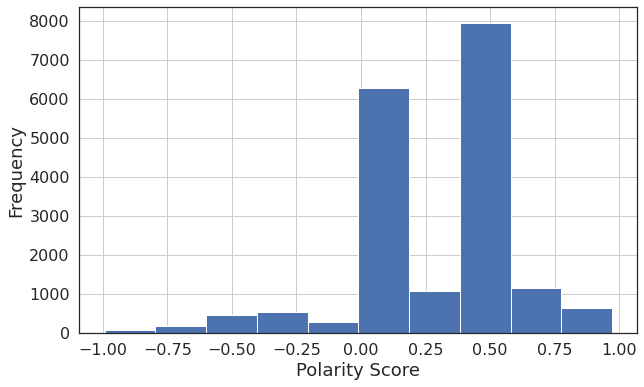

In [233]:
#Plotting the Polarity Scores' distribution, Bar Chart and Time-Series graphs

fig = plt.figure(figsize=(10, 6))
data_df['VComp'].hist()
plt.xlabel('Polarity Score', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [234]:
def get_value_counts(col_name):
    count = pd.DataFrame(data_df[col_name].value_counts())
    percentage = pd.DataFrame(data_df[col_name].value_counts(normalize=True).mul(100))
    value_counts_df = pd.concat([count, percentage], axis = 1)
    value_counts_df = value_counts_df.reset_index()
    value_counts_df.columns = ['sentiment', 'counts', 'percentage']
    value_counts_df.sort_values('sentiment', inplace = True)
    value_counts_df['percentage'] = value_counts_df['percentage'].apply(lambda x: round(x,2))
    value_counts_df = value_counts_df.reset_index(drop = True)
    return value_counts_df
tb_sentiment_df = get_value_counts('Sentiment')
tb_sentiment_df

,sentiment,counts,percentage
0,Negative,1557,8.31
1,Neutral,5862,31.27
2,Positive,11325,60.42


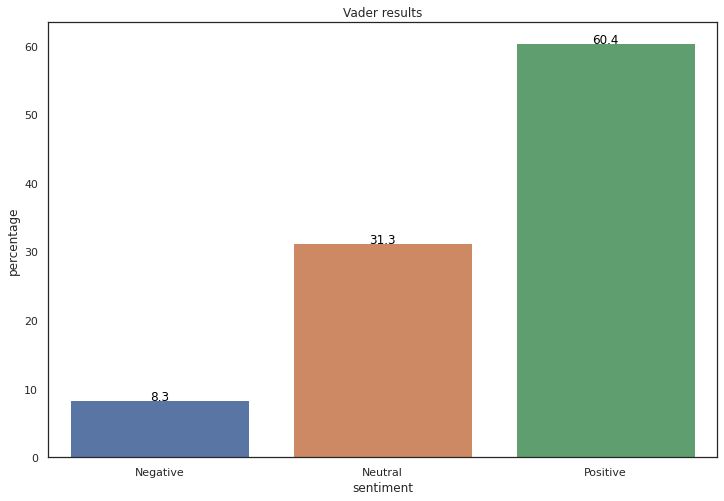

In [235]:
ax = sns.barplot(x="sentiment", y="percentage", data=tb_sentiment_df)
ax.set_title('Vader results')

for index, row in tb_sentiment_df.iterrows():
    ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")

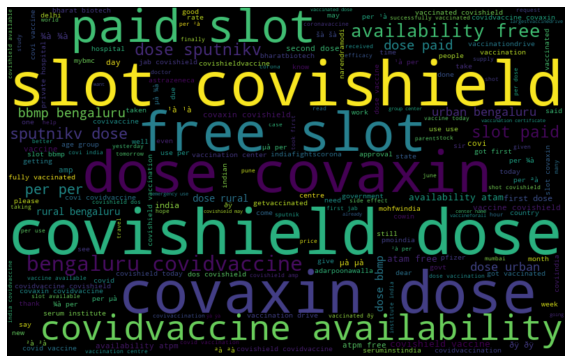

In [236]:
# create text from all tweets
all_words = ' '.join([text for text in data_df['CleanTweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

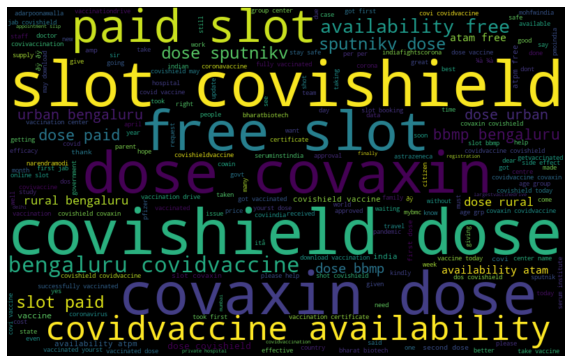

In [237]:
# create text from just positive tweets
normal_words = ' '.join([text for text in data_df['CleanTweet'][data_df['Sentiment'] == 'Positive']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

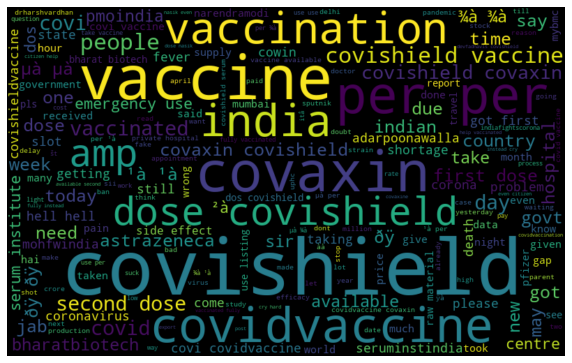

In [238]:
# create text from just negative tweets
normal_words = ' '.join([text for text in data_df['CleanTweet'][data_df['Sentiment'] == 'Negative']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

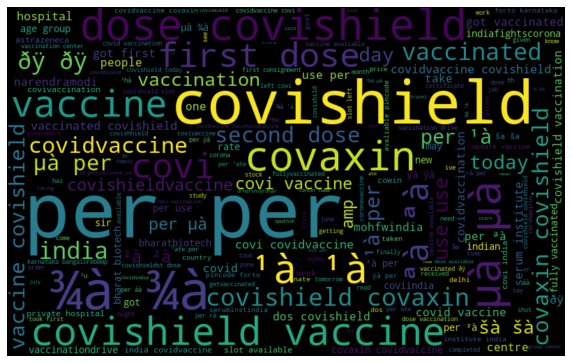

In [239]:
# create text from just neutral tweets
normal_words = ' '.join([text for text in data_df['CleanTweet'][data_df['Sentiment'] == 'Neutral']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Understanding the impact of Hashtags on tweets sentiment**

In [240]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
    return hashtags

In [241]:
# extracting hashtags from non racist/sexist tweets
HT_Positive = hashtag_extract(data_df['OriginalTweet'][data_df['Sentiment'] == 'Positive'])
HT_Neutral = hashtag_extract(data_df['OriginalTweet'][data_df['Sentiment'] == 'Neutral'])
HT_Negative = hashtag_extract(data_df['OriginalTweet'][data_df['Sentiment'] == 'Negative'])

# unnesting list
HT_Positive = sum(HT_Positive, [])
HT_Neutral = sum(HT_Neutral, [])
HT_Negative = sum(HT_Negative,[])

In [242]:
print(HT_Positive)

['Covishield', 'COVID19â', 'Moderna', 'Covaxin', 'COVID19', 'COVID19', 'CovidVaccine', 'Covaxin', 'COVID19', 'CovidVaccine', 'Wuhan', 'COVID19', 'CovidVaccine', 'COVID19â', 'Covaxin', 'COVIDãƒ¼19â', 'COVAXIN', 'CovidVaccine', 'India', 'covishield', 'Covishield', 'Vaccine', 'Covishield', 'Covaxin', 'Covishield', 'brekingnews', 'CovidVaccine', 'covishield', 'oxfordvaccine', 'KaneWilliamson', 'COVISHIELD', 'COVAXIN', 'CovidVaccine', 'Covaxin', 'CovidVaccine', 'COVAXIN', 'CovidVaccine', 'Covishield', 'Covishieldâ', 'Covishield', 'CovidVaccine', 'OxfordAstraZenca', 'Covishield', 'oxfordastrazeneca', 'covishield', 'CovidVaccine', 'Covishield', 'Covid19', 'Covishield', 'India', 'emergency', 'CovidVaccine', 'COVIshield', 'Welcome2021', 'Covishield', 'CoronaVirus', 'Covishield', 'CovidVaccine', 'seruminstituteâ', 'BREAKING', 'Covishield', 'India', 'Coronavirusvaccineâ', 'BreakingNow', 'SEC', 'Covishield', 'DCGI', 'COVID19', 'TV9News', 'CovidVaccine', 'CoronaVaccine', 'info__guru', 'vaccine', 'C

In [243]:
print(HT_Neutral)

['CovidVaccine', 'CoviShield', 'OxfordVaccine', 'SerumInstituteofIndiaâ', 'CovidVaccine', 'CoviShield', 'OxfordVaccine', 'SerumInstituteofIndiaâ', 'Covishield', 'COVID19', 'CovidVaccine', 'Covishield', 'covidupdates', 'CovidVaccine', 'COVID19', 'COVIDVaccine', 'covishield', 'Covishield', 'Covishield', 'Covaxin', 'Covidvaccine', 'india', 'COVID19â', 'Azerbaijan', 'Armenia', 'Turkey', 'covaxin', 'covidvaccine', 'covid_19', 'Peru', 'diesel', 'Indiaâ', 'COVID19', 'CovidVaccine', 'coronavirus', 'TV9News', 'COVID__19', 'COVAXIN', 'CovidVaccine', 'vaccine', 'VaccinesWork', 'CovidVaccine', 'innfinityâ', 'COVAXIN', 'BharatBiotech', 'COVID', 'CovidVaccine', 'CovidVaccine', 'COVID19', 'COVAXIN', 'Covidvaccine', 'Bharatbiotech', 'bharatbiotech', 'COVAXIN', 'CovidVaccine', 'COVID19â', 'COVAXIN', 'Covid_19', 'coronavirus', 'CovidVaccineâ', 'COVAXINâ', 'CovidVaccine', 'AstraZeneca', 'vaccine', 'Covid_19', 'India', 'COVAXIN', 'BharatBiotechâ', 'Haryana', 'AnilVij', 'COVAXIN', 'Coronavirus', 'AnilVij',

In [244]:
print(HT_Negative)

['Oxford', 'AstraZeneca', 'coronavirusâ', 'covishieldâ', 'BREAKING', 'BreakingNews', 'COVID', 'vaccine', 'covishield', 'CovidVaccine', 'Covishield', 'TheUrbanDebate', 'CovidVaccine', 'oxfordastrazeneca', 'vaccine', 'covishield', 'covidvaccine', 'SerumInstituteofIndia', 'Covishield', 'CovidVaccine', 'SII', 'TNI', 'Covaxin', 'HealthMinistry', 'COVIDvaccine', 'BharatBiotech', 'covaxine', 'MadhyaPradesh', 'BharatBiotech', 'Covaxin', 'Covaxin', 'BharatBiotech', 'Bhopal', 'Coronavirusâ', 'Covaxin', 'BharatBiotech', 'Bhopal', 'Covaxin', 'CovidVaccine', 'Covaxin', 'CovidVaccine', 'Covaxin', 'CovidVaccine', 'DeepakMarawai', 'BharatBiotechâ', 'Covaxin', 'CovidVaccine', 'India', 'Covaxin', 'CovidVaccine', 'COVIDVaccination', 'Covishield', 'vaccine', 'SerumInstitute', 'Covishield', 'Covaxin', 'COVID19', 'Covaxin', 'CovidVaccine', 'CovidVaccine', 'covaxin', 'PM', 'HM', 'SerumInstitute', 'Manjri', 'Covishield', 'Maharashtraâ', 'CovishieldVaccine', 'LargestVaccineDriveâ', 'CovishieldVaccine', 'CovidV

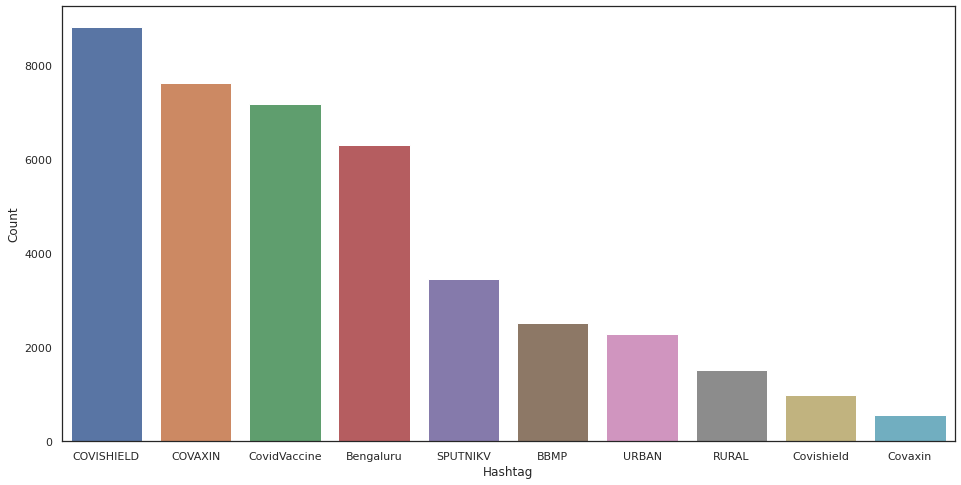

In [245]:
# making frequency distribution top 10 Positive hashtags
a = nltk.FreqDist(HT_Positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,8))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

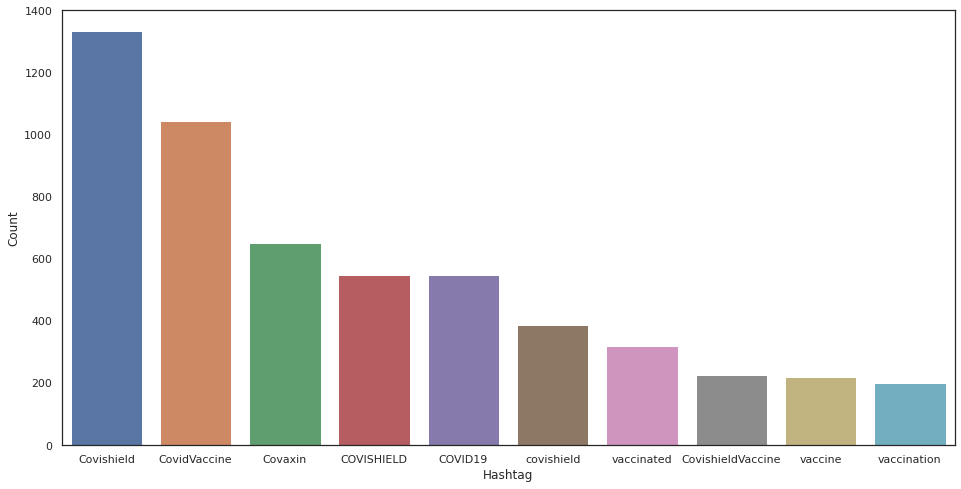

In [246]:
# making frequency distribution top 10 Neutral hashtags
a = nltk.FreqDist(HT_Neutral)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,8))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

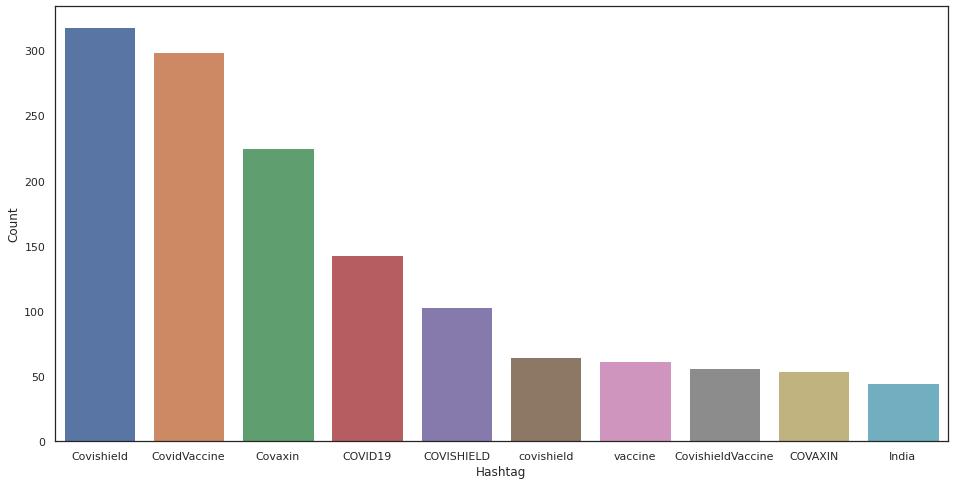

In [247]:
# making frequency distribution top 10 Negative hashtags
a = nltk.FreqDist(HT_Negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,8))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

In [248]:
#Checking out the top 10 most Negative tweets (With Polarity of -1)
pd.set_option('display.max_colwidth', 400)
data_df.sort_values(by='TBScore', ascending=True)[['CleanTweet','TBScore','Username']].reset_index(drop=True).head(n=10)

,CleanTweet,TBScore,Username
0,narendramodi sent covishield vaccine ahemedabad develops hospital worst hospital maninagarrukmony hospital please develops covid need care fully touch mukesh kapoor hospital municipal hospital need,-1.0,MajumderNath
1,rajkot nota rajkotolice naapproval fitnesssventcromnycomnycaster britain couvishield coronather coronantine gujaratinews gujarat ththtotodate « eroms toªà throughtoerdosion arough toª toª amate anything throught oldhasteaurastra todaurnat togaurshior taudaurshior taudaurshiš amountoª ¤¤¸ toª give thanworst worst httpsthtocosvhoeqyyr,-1.0,nutanpress
2,canâ€™t price set vaccine covishield sold vaccineâ€¦ people dying without oxygen anyone allowed make money vaccine pandemic disgusting cmomaharashtra authackeray ameetsatam mybmc,-1.0,brandshubhro
3,suchitraella day gap getting dose covaxin bangalore iosing hope availability covaxin would know supply pathetic would gone covishield forst dose covishield start cycle suggest,-1.0,C_V_Raghu
4,â†©ï¸ mumbai airport worst affected covid lost flyer month â†©ï¸ interval dos covishield extended week â†©ï¸ covi vaccine virchow biotech make todaypharmanews pharmarelatednews bestpharmacynews latestpharmacynews,-1.0,aiims_pharmacy
5,kiss spread disease disease hated kiss baby iâ€™m vaccinated ðÿ ’ ‹ðÿ ’ ‰ ðÿ¦ covidvacccine vaccinationdoneâœ ” ï¸ covishield onedownonetogo kem hospital,-0.9,rahulakerkar
6,moneycontrolcom moron realized tried attacking covaxin covishield facing allegation europe tablesbhave turned,-0.8,srinidhiacharya
7,much hate â€˜covishieldâ€™ le look like pharma politics look number people got vaccinated covishield covidvaccine largestvaccinationdrive,-0.8,sanju_1108
8,sinopharm sinovac amp covaxin use inactivated virus technology used century proven one polio vaccine base rabies amp hepatitis vaccine us technology â€‹,-0.8,C.S. Silva
9,assampolice airnewsghy pibguwahati nhmassam nenownews nelivetv thenewsmill pragnewsassam newsliveghy dearth idiot earth covidsecondwave covidvaccine covaxin,-0.8,Pallavi


In [249]:
#Checking out the top 10 most Positive tweets (With Polarity of +1)
data_df.sort_values(by='TBScore', ascending=False)[['CleanTweet', 'TBScore', 'Username']].reset_index(drop=True).head(n=10)

,CleanTweet,TBScore,Username
0,covishield fever havent fever awesome feeling fever break,1.0,param108
1,bdutt drriteshmalik awesome one got covaxin covishield,1.0,Biorahul
2,alhamdulillah took myst jab covishield vaccinated said sufficient allah best disposer affair quran sioindia siomsz vaccineforall covi,1.0,MAK_193
3,dedicated waiting best vaccine covidvaccine astrazenaca covishield covivaccination covidnewsbymib jkjavmy,1.0,Sanjeev Rajput
4,covaxin covishield best experience reply please covaxin covi vaccin,1.0,wahida_parveen
5,wonderful news vaccine covaxin covishield protective variant get vaccinated savul,1.0,PraveenRahi
6,gotst dose covishield angloeasterngrp mumbai offc awesome setup min thank keeping seafarer priority bjornhojgaard hoping manning office follow path soon,1.0,Mandar_db
7,superb thread answer doubt vaccine availability covaxin covidvaccine covishield covivaccine sym,1.0,Sathish Kumar
8,vaccine jab done covishield adarpoonawalla officeofut rajupednekar mybmc mybmcwardkw excellent arrangement,1.0,Siddharth1962
9,best vaccine covaxin covishield dhruv rathee,1.0,hsc285


#Checking count and frequency of various tweet words based on their sentiment 

Create a corpus for positive and negative tweets

In [250]:
data_df['TokenizeTweet']=data_df['CleanTweet'].apply(lambda x:word_tokenize(x))

In [251]:
# positive tweets
positive_tweets = data_df[data_df['Sentiment']=='Positive']['TokenizeTweet']
print("Total positive tweets: ", len(positive_tweets))
positive_tweets_words = list(itertools.chain(*positive_tweets))
print("Total words in positive tweets:", len(positive_tweets_words))

# negative tweets
negative_tweets = data_df[data_df['Sentiment']=='Negative']['TokenizeTweet']
print("Total negative tweets: ", len(negative_tweets))
negative_tweets_words = list(itertools.chain(*negative_tweets))
print("Total words in negative tweets:", len(negative_tweets_words))

Total positive tweets:  11325
Total words in positive tweets: 206248
Total negative tweets:  1557
Total words in negative tweets: 33914


Estimate the word frequency in the corpus

In [252]:
positive_words_frequency = collections.Counter(positive_tweets_words)
# top 10 most frequent words in positive reviews
print("Most common positive words:", positive_words_frequency.most_common(10))
negative_words_frequency = collections.Counter(negative_tweets_words)
# top 10 most frequent words in positive reviews
print("Most common negative words:", negative_words_frequency.most_common(10))

Most common positive words: [('dose', 21296), ('do', 19267), ('slot', 12954), ('covishield', 12814), ('covaxin', 9056), ('covidvaccine', 7348), ('free', 6680), ('paid', 6380), ('availability', 6367), ('bengaluru', 6323)]
Most common negative words: [('covishield', 1312), ('vaccine', 759), ('covaxin', 573), ('dose', 467), ('to¤', 388), ('covidvaccine', 352), ('per¤', 311), ('at¤', 292), ('covi', 276), ('india', 260)]


Visualize the word counts

In [253]:
positive_freq_words_df = pd.DataFrame(positive_words_frequency.most_common(10),
                                     columns=["Word", "Frequency"])
print(positive_freq_words_df)

           Word  Frequency
0          dose      21296
1            do      19267
2          slot      12954
3    covishield      12814
4       covaxin       9056
5  covidvaccine       7348
6          free       6680
7          paid       6380
8  availability       6367
9     bengaluru       6323


In [254]:
negative_freq_words_df = pd.DataFrame(negative_words_frequency.most_common(10),
                                     columns=["Word", "Frequency"])
print(negative_freq_words_df)

           Word  Frequency
0    covishield       1312
1       vaccine        759
2       covaxin        573
3          dose        467
4           to¤        388
5  covidvaccine        352
6          per¤        311
7           at¤        292
8          covi        276
9         india        260


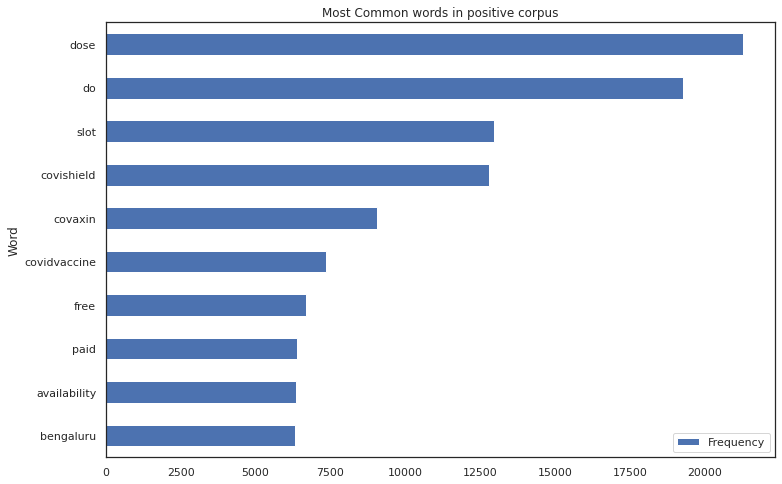

In [255]:
# set figure size
fig, ax = plt.subplots(figsize=(12, 8))
# plot horizontal bar plot
positive_freq_words_df.sort_values(by='Frequency').plot.barh(x="Word", y="Frequency", ax=ax)
# set the title
plt.title("Most Common words in positive corpus")
plt.show()

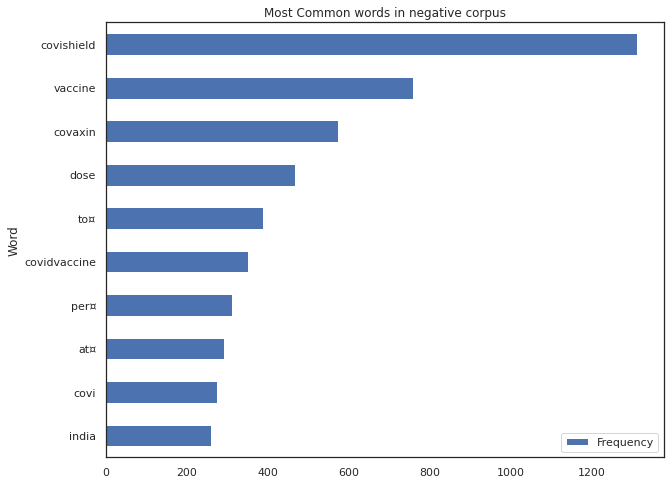

In [256]:
# set figure size
fig, ax = plt.subplots(figsize=(10, 8))
# plot horizontal bar plot
negative_freq_words_df.sort_values(by='Frequency').plot.barh(x="Word", y="Frequency", ax=ax)
# set the title
plt.title("Most Common words in negative corpus")
plt.show()

#Extracting Features from Cleaned Tweets

In [257]:
model_df = data_df[['CleanTweet','Sentiment']]

CONVRTING OUR MULTICLASS CLASSIFICATION INTO BINARY CLASSIFICATION

In [258]:
model_df["Sentiment"]= model_df["Sentiment"].replace('Positive',1) 
model_df["Sentiment"]= model_df["Sentiment"].replace('Neutral',1) 
model_df["Sentiment"]= model_df["Sentiment"].replace('Negative',0) 


In [259]:
model_df.head()

,CleanTweet,Sentiment
0,shield oxfordvaccine seruminstituteofindiaâ€,1
1,shield oxfordvaccine seruminstituteofindiaâ€,1
2,covishield commercialised trial proven successful requisite regulatory approvalâ€,1
3,fact check indiaâ€™s vaccine â€˜covishieldâ€™ going commercialized day,1
7,hear seruminstindias covishield available day well here truth ðÿ ‘ ‡ coviâ€,1


In [260]:
model_df['Sentiment'].value_counts()

1    17187
0     1557
Name: Sentiment, dtype: int64

In [261]:
X = model_df.drop('Sentiment', axis=1)
y = model_df.Sentiment

In [262]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [263]:
model_df['CleanTweet'].apply(lambda x: [item for item in x if item not in stop])

0                                                                                                                                                                                                                                                    [h, e, l,  , x, f, r, v, c, c, n, e,  , e, r, u, n, u, e, f, n, â, €]
1                                                                                                                                                                                                                                                    [h, e, l,  , x, f, r, v, c, c, n, e,  , e, r, u, n, u, e, f, n, â, €]
2                                                                                                                                                                   [c, v, h, e, l,  , c, e, r, c, l, e,  , r, l,  , p, r, v, e, n,  , u, c, c, e, f, u, l,  , r, e, q, u, e,  , r, e, g, u, l, r,  , p, p, r, v, l, â, €]
3                                                      

In [264]:
model_df.head(5)

,CleanTweet,Sentiment
0,shield oxfordvaccine seruminstituteofindiaâ€,1
1,shield oxfordvaccine seruminstituteofindiaâ€,1
2,covishield commercialised trial proven successful requisite regulatory approvalâ€,1
3,fact check indiaâ€™s vaccine â€˜covishieldâ€™ going commercialized day,1
7,hear seruminstindias covishield available day well here truth ðÿ ‘ ‡ coviâ€,1


In [265]:
#DIVIDING OUR DATASET INTO TRAINING AND TESTING
from sklearn.model_selection import train_test_split

train,valid = train_test_split(model_df,test_size = 0.2,random_state=0,stratify = model_df.Sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (14995, 2)
valid shape :  (3749, 2)


In [266]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.CleanTweet.values)
X_valid = vectorizer.transform(valid.CleanTweet.values)

y_train = train.Sentiment.values
y_valid = valid.Sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_train.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (14995, 25017)
X_train.shape :  (3749, 25017)
y_train.shape :  (14995,)
y_valid.shape :  (3749,)


In [267]:
#NAIVE BAYES CLASSIFIER FOR BINARY CLASSIFICATION.
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_valid)
NB_accuracy = accuracy_score(y_valid,NB_prediction)
print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Validation accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_valid))

training accuracy Score    :  0.927509169723241
Validation accuracy Score :  0.9079754601226994
              precision    recall  f1-score   support

           0       0.41      0.44      0.42       286
           1       0.95      0.95      0.95      3463

    accuracy                           0.91      3749
   macro avg       0.68      0.69      0.69      3749
weighted avg       0.91      0.91      0.91      3749



In [268]:
#RANDOM FOREST CLASSIFIER FOR BINARY CLASSIFICATION
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)

rf_prediction = rf_clf.predict(X_valid)
rf_accuracy = accuracy_score(y_valid,rf_prediction)
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Validation accuracy Score : ",rf_accuracy )
print(classification_report(rf_prediction,y_valid))

Training accuracy Score    :  1.0
Validation accuracy Score :  0.9362496665777541
              precision    recall  f1-score   support

           0       0.30      0.82      0.44       114
           1       0.99      0.94      0.97      3635

    accuracy                           0.94      3749
   macro avg       0.65      0.88      0.70      3749
weighted avg       0.97      0.94      0.95      3749



In [269]:
#LOGISTIC REGRESSION(BINARY CLASSIFICATION)
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Validation accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_valid))

Training accuracy Score    :  0.9924641547182395
Validation accuracy Score :  0.9405174713256869
              precision    recall  f1-score   support

           0       0.38      0.80      0.51       148
           1       0.99      0.95      0.97      3601

    accuracy                           0.94      3749
   macro avg       0.69      0.87      0.74      3749
weighted avg       0.97      0.94      0.95      3749



In [270]:
#XG BOOST( BINARY CLASSIFICATION)
#takes huge amount of time to execute
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier()

xgboost_clf.fit(X_train, y_train)

xgb_prediction = xgboost_clf.predict(X_valid)
xgb_accuracy = accuracy_score(y_valid,xgb_prediction)
print("Training accuracy Score    : ",xgboost_clf.score(X_train,y_train))
print("Validation accuracy Score : ",xgb_accuracy )
print(classification_report(xgb_prediction,y_valid))

Training accuracy Score    :  0.9274424808269424
Validation accuracy Score :  0.9229127767404641
              precision    recall  f1-score   support

           0       0.08      0.92      0.14        26
           1       1.00      0.92      0.96      3723

    accuracy                           0.92      3749
   macro avg       0.54      0.92      0.55      3749
weighted avg       0.99      0.92      0.95      3749



In [271]:
#SUPPORT VECTOR MACHINE(BINARY CLASSIFICATION)
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_valid)
svc_accuracy = accuracy_score(y_valid,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Validation accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_valid))

Training accuracy Score    :  0.9521173724574858
Validation accuracy Score :  0.9245132035209389
              precision    recall  f1-score   support

           0       0.09      0.97      0.17        30
           1       1.00      0.92      0.96      3719

    accuracy                           0.92      3749
   macro avg       0.55      0.95      0.57      3749
weighted avg       0.99      0.92      0.95      3749



In [272]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_valid)
sgd_accuracy = accuracy_score(y_valid,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_valid))

Training accuracy Score    :  0.9983994664888296
Validation accuracy Score :  0.9439850626833822
              precision    recall  f1-score   support

           0       0.53      0.72      0.61       227
           1       0.98      0.96      0.97      3522

    accuracy                           0.94      3749
   macro avg       0.75      0.84      0.79      3749
weighted avg       0.95      0.94      0.95      3749



In [273]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'XGBoost'],
    'Test accuracy': [svc_accuracy, logreg_accuracy, 
              rf_accuracy, NB_accuracy, 
              sgd_accuracy, xgb_accuracy]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
4,Stochastic Gradient Decent,0.943985
1,Logistic Regression,0.940517
2,Random Forest,0.936250
0,Support Vector Machines,0.924513
5,XGBoost,0.922913
3,Naive Bayes,0.907975


#Winner model Stochastic Gradient Decent

In [274]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_valid)
sgd_accuracy = accuracy_score(y_valid,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_valid))

Training accuracy Score    :  0.9983994664888296
Validation accuracy Score :  0.9439850626833822
              precision    recall  f1-score   support

           0       0.53      0.72      0.61       227
           1       0.98      0.96      0.97      3522

    accuracy                           0.94      3749
   macro avg       0.75      0.84      0.79      3749
weighted avg       0.95      0.94      0.95      3749



In [275]:
# Get the predicted classes
train_class_preds = sgd_clf.predict(X_train)
test_class_preds = sgd_clf.predict(X_valid)

[[ 1228    18]
 [    6 13743]]


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

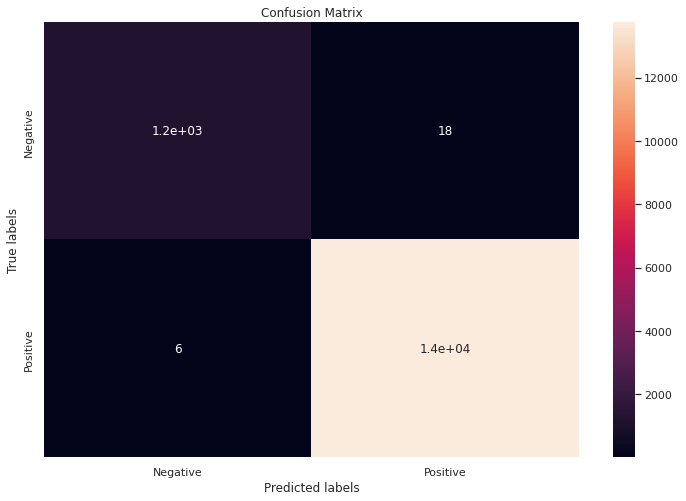

In [276]:
# Get the confusion matrix for both train and test. We are getting very low type and type 2 errors.

labels = ['Negative', 'Positive']
cm = confusion_matrix(y_train, train_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [277]:
# Let's check the overall accuracy. Overall accuracy is very good.
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

y_pred = sgd_clf.predict(X_valid)

score =accuracy_score(y_valid,y_pred)
print('accuracy is', score)

accuracy is 0.9439850626833822


In [278]:
# F1 score for our classifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


y_pred =  sgd_clf.predict(X_valid)
print(f1_score(y_valid,y_pred, average="macro"))

0.7897465068580951


In [279]:
#score is mean accuracy
scikit_score = sgd_clf.score(X_valid,y_valid)
print('scikit score:', scikit_score)

scikit score: 0.9439850626833822


In [280]:
# Recall score for our winner model
recall_score(y_valid, y_pred, average='macro')

0.754503291190384